In [398]:
import pandas as pd
import pandas_profiling as pdpf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow import feature_column

from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from tensorflow.keras import layers
import itertools as it

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr

# from tensorboard.plugins.hparams import api as hp
print("GPU Available: ", tf.test.is_gpu_available())

2.1.0
GPU Available:  True


<h3> Global Variables </h3>

In [399]:
BATCH_SIZE = 64
TEST_SPLIT = 0.2
PATIENCE = 10

<h3> Get the data </h3>

In [418]:
# input_path = "gs://agriculture-sara/Test_manual.csv"
input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/All_Manual_Daily_Albedo_NDVI_LST.csv"
df = pd.read_csv(input_path, delimiter=',')
df.head()

# columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
#                  'G','G-1','G-2','G-3','G-4','G-5',
#                  'H', 'H_CORRECTED', 'H_CORRECTED-1', 'H_CORRECTED-2', 'H_CORRECTED-3', 'H_CORRECTED-4',
#                  'H_CORRECTED-5', 'C_BOWENS',
#                  'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
#                  'LE', 'LE_CORRECTED', 'LE_CORRECTED(mm)-1', 'LE_CORRECTED(mm)-2',
#                  'LE_CORRECTED(mm)-3', 'LE_CORRECTED(mm)-4',
#                 'LE_CORRECTED(mm)-5']

columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
                 'Climate', 'Vegetation', 'Latitude', 'Longitude',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                 'H_bowen_corr-5', 'C_BOWENS',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_bowen_corr',
                 'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                 'Elevation(m)_5', 'Elevation(m)_6',
                 'ETo', 'EToF', 'ETr', 'ETrF']

df.dropna(inplace=True)
df = df.drop(columnsToDrop, axis = 1)


df.rename(columns={"Site Id_1": "Site_1", "Site Id_2": "Site_2",
                  "Site Id_3": "Site_3", "Site Id_4": "Site_4",
                  "Site Id_5": "Site_5", "Site Id_6": "Site_6",
                   "EEflux LST": "EEflux_LST", "EEflux NDVI" : "EEflux_NDVI",
                   "EEflux Albedo" : "EEFlux_Albedo"}, inplace=True)



# output_column = "LE_CORRECTED(mm)"
output_column = "LE_bowen_corr(mm)"
X = df.drop([output_column], axis = 1)
Y = df[output_column]

print(X.shape, Y.shape)

(1883, 50) (1883,)


In [419]:
df.columns

Index(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Climate_1', 'Climate_2', 'Climate_3',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'Latitude_1',
       'Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5', 'Latitude_6',
       'Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
       'Longitude_5', 'Longitude_6', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'SW_IN', 'LE_bowen_corr(mm)',
       'EEflux_LST', 'EEflux_NDVI', 'EEFlux_Albedo'],
      dtype='object')

<h3> Data Profiling </h3>

In [420]:
# pdpf.ProfileReport(df)

<h3> Train, val, test Split </h3>

In [421]:
train, test = train_test_split(df, test_size=TEST_SPLIT)
train, val = train_test_split(train, test_size=TEST_SPLIT)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1204 train examples
302 validation examples
377 test examples


<h3> Create an input pipeline using tf.data </h3>

In [422]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(output_column)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

train_ds = df_to_dataset(train, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test, shuffle=False, batch_size=BATCH_SIZE)

In [423]:
for feature_batch, label_batch in train_ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['WS'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['RH', 'Month_3', 'TA-5', 'Month_4', 'Longitude_3', 'Latitude_4', 'Vegetation_2', 'TA-2', 'TA-3', 'WS-4', 'Site_2', 'Latitude_1', 'Latitude_5', 'WS-2', 'TA', 'Site_4', 'RH-3', 'Month_2', 'WS-3', 'WS-1', 'Longitude_2', 'Climate_2', 'TA-4', 'Site_5', 'Latitude_3', 'Site_1', 'WS', 'RH-2', 'Month_1', 'Site_6', 'RH-1', 'TA-1', 'Climate_3', 'Vegetation_3', 'Latitude_6', 'Climate_1', 'WS-5', 'Longitude_6', 'Longitude_5', 'SW_IN', 'RH-4', 'Latitude_2', 'Longitude_4', 'EEflux_NDVI', 'RH-5', 'Longitude_1', 'Site_3', 'EEFlux_Albedo', 'EEflux_LST', 'Vegetation_1']

A batch of class: [2.2485313 2.2016666 3.6471193 1.5725    2.402593  1.2187234 1.1602083
 1.8156595 1.9637778 1.15      3.7990625 1.8070834 5.7727575 1.9921458
 5.497978  3.1766555 2.0176876 4.302273  2.9966667 3.9884772 0.8047917
 1.5875    2.1173334 6.693021  1.7793617 5.4497776 2.3884168 1.2593305
 1.3173542 1.1676042 1.2627292 4.0269375 2.1131916 2.574979  1.3592789
 1.9152273 2.0040476 2.188875  2.0979166 3.11697

<h3> Feature columns types </h3>

<h3> Scale data </h3>

In [424]:
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
    return(minmax)

<h3> Create Feature Columns </h3>

In [425]:
# Numerical columns
input_columns = list(df.columns)
input_columns.remove(output_column)
print(input_columns)

num_c = input_columns
feature_columns = []
for header in num_c:
    scal_input_fn = get_scal(header)
    #Since all features are numeric
    feature_columns.append(tf.feature_column.numeric_column(header, normalizer_fn=scal_input_fn))
    
print(len(feature_columns))

['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Climate_1', 'Climate_2', 'Climate_3', 'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'Latitude_1', 'Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5', 'Latitude_6', 'Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4', 'Longitude_5', 'Longitude_6', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'SW_IN', 'EEflux_LST', 'EEflux_NDVI', 'EEFlux_Albedo']
50


<h3> Create a feature layer </h3>

In [426]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

<h3> Build Model </h3>

In [427]:
def train_test_model(hparams):
    
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(hparams["HP_NUM_UNITS1"], kernel_initializer=hparams["HP_INIT"],
                 kernel_regularizer=tf.keras.regularizers.l2(0.001),
                 activation=hparams["HP_ACTIVATION"]),
    layers.Dropout(hparams["HP_DROPOUT"]),
    layers.Dense(hparams["HP_NUM_UNITS2"], kernel_regularizer=tf.keras.regularizers.l2(0.001),
                 activation=hparams["HP_ACTIVATION"]),
    layers.Dense(1, activation='linear')
  ])
    optimizer = tf.keras.optimizers.SGD(
    learning_rate=hparams["HP_LEARNING_RATE"], momentum=hparams["HP_MOMENTUM"], name='SGD')
    model.compile(optimizer=hparams["HP_OPTIMIZER"], loss=hparams["HP_LOSS"], metrics=['accuracy', 'mse', 'mae'])

    
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=hparams["HP_EPOCHS"],
                        verbose = 1,
                        callbacks=[])
    
    return (model, history)

## Build Hyper Parameter Dictionary

In [428]:
#Chapter 2: Configure Capacity with Nodes and Layers
# hparams = {
#     "HP_NUM_UNITS1": ["64"],
#     "HP_NUM_UNITS2": ["150"],
#     "HP_DROPOUT": [0],
#     "HP_L2": [0.001],
#     "HP_OPTIMIZER": ["adam"],
#     "HP_ACTIVATION": ["relu"],
#     "HP_INIT": ["uniform"],
#     "HP_EPOCHS": [300],
#     "HP_BATCH_SIZE": [64],
#     "HP_LAYER_SIZE": [1, 2, 4, 6]
# }

#Chapter 4: Configure Capacity with Nodes and Layers
hparams = {
    "HP_NUM_UNITS1": ["64"],
    "HP_NUM_UNITS2": ["64"],
    "HP_DROPOUT": [0.2],
    "HP_L2": [0.001],
    "HP_OPTIMIZER": ["adam"],
    "HP_ACTIVATION": ["relu"],
    "HP_INIT": ["uniform"],
    "HP_EPOCHS": [300],
    "HP_BATCH_SIZE": [64],
    "HP_LAYER_SIZE": [1],
    "HP_LOSS": ["mean_squared_error", "mean_squared_logarithmic_error", "mean_absolute_error"],
    "HP_LEARNING_RATE": [0.01],
    "HP_MOMENTUM": [0.5]
}

#Chapter 5: Configure Speed of Learning with Learning Rate
# hparams = {
#     "HP_NUM_UNITS1": ["64"],
#     "HP_NUM_UNITS2": ["64"],
#     "HP_DROPOUT": [0.2],
#     "HP_L2": [0.001],
#     "HP_OPTIMIZER": ["adam"],
#     "HP_ACTIVATION": ["relu"],
#     "HP_INIT": ["uniform"],
#     "HP_EPOCHS": [200],
#     "HP_BATCH_SIZE": [64],
#     "HP_LAYER_SIZE": [1],
#     "HP_LOSS": ["mean_squared_error"],
#     "HP_LEARNING_RATE": [0.01],
#     "HP_MOMENTUM": [0.0, 0.5, 0.9, 0.99]
# }


#get grid of all hyper-parameters
def get_param_grid(dicts):
    return [dict(zip(dicts.keys(), p)) for p in it.product(*dicts.values())]

def get_fold_indices(X,y,n_splits):
    splitter = KFold(n_splits=n_splits, shuffle=True, random_state=123)
    folds = list(splitter.split(X, y))
    return folds

In [429]:
# train_np = np.stack(list(train_ds))
# print(type(train_np), train_np.shape)

In [430]:
X_train = train.drop([output_column], axis = 1)
Y_train = train[output_column]

X_test = test.drop([output_column], axis = 1)
Y_test = test[output_column]

## Perform Grid Search with K-Fold

In [431]:
error_list = []
error_folds = []
folds = 2
repetitions = 1

grid_search = get_param_grid(hparams)

for param in grid_search:
    print("Parameters:", param)
    error_rep = []
    for rep in range(repetitions):
        fold_index = get_fold_indices(X_train, Y_train, folds)
        error_folds = []
        for fold in range(folds):
            model, history = train_test_model(param)
            loss = history.history["loss"]
            error_folds.append(loss)
        avg = np.average(error_folds)
        print("the average error across folds is " + str(avg))
        error_rep.append(avg)
    avg_rep = np.average(error_rep)
    error_list.append(avg_rep)

print(min(error_list) , " is the best error")
index = error_list.index(min(error_list))
print(grid_search[index], " is the best hyper-params")

Parameters: {'HP_LEARNING_RATE': 0.01, 'HP_MOMENTUM': 0.5, 'HP_OPTIMIZER': 'adam', 'HP_NUM_UNITS2': '64', 'HP_NUM_UNITS1': '64', 'HP_L2': 0.001, 'HP_BATCH_SIZE': 64, 'HP_EPOCHS': 300, 'HP_LOSS': 'mean_squared_error', 'HP_INIT': 'uniform', 'HP_LAYER_SIZE': 1, 'HP_DROPOUT': 0.2, 'HP_ACTIVATION': 'relu'}
Train for 19 steps, validate for 5 steps
Epoch 1/300
19/19 [==============================] - 2s 130ms/step - loss: 12.3212 - accuracy: 0.0000e+00 - mse: 12.3280 - mae: 2.2493 - val_loss: 5.0232 - val_accuracy: 0.0000e+00 - val_mse: 4.9606 - val_mae: 1.7704
Epoch 2/300
19/19 [==============================] - 0s 17ms/step - loss: 8.6058 - accuracy: 0.0000e+00 - mse: 8.5639 - mae: 1.7612 - val_loss: 4.7135 - val_accuracy: 0.0000e+00 - val_mse: 4.6501 - val_mae: 1.6545
Epoch 3/300
19/19 [==============================] - 0s 18ms/step - loss: 7.9080 - accuracy: 0.0000e+00 - mse: 7.8938 - mae: 1.6109 - val_loss: 4.1140 - val_accuracy: 0.0000e+00 - val_mse: 4.0521 - val_mae: 1.5323
Epoch 4/300

## Train Model with Best Hyper Parameters

In [432]:
model, history = train_test_model(grid_search[index])

Train for 19 steps, validate for 5 steps
Epoch 1/300
19/19 [==============================] - 3s 133ms/step - loss: 0.7261 - accuracy: 0.0000e+00 - mse: 12.0499 - mae: 2.2442 - val_loss: 0.3529 - val_accuracy: 0.0000e+00 - val_mse: 5.0513 - val_mae: 1.7101
Epoch 2/300
19/19 [==============================] - 0s 18ms/step - loss: 0.3575 - accuracy: 0.0000e+00 - mse: 8.1916 - mae: 1.6963 - val_loss: 0.3342 - val_accuracy: 0.0000e+00 - val_mse: 4.7158 - val_mae: 1.6566
Epoch 3/300
19/19 [==============================] - 0s 18ms/step - loss: 0.3262 - accuracy: 0.0000e+00 - mse: 8.3316 - mae: 1.6766 - val_loss: 0.3099 - val_accuracy: 0.0000e+00 - val_mse: 4.9428 - val_mae: 1.6331
Epoch 4/300
19/19 [==============================] - 0s 18ms/step - loss: 0.2971 - accuracy: 0.0000e+00 - mse: 7.9218 - mae: 1.5964 - val_loss: 0.2776 - val_accuracy: 0.0000e+00 - val_mse: 4.3607 - val_mae: 1.5234
Epoch 5/300
19/19 [==============================] - 0s 18ms/step - loss: 0.2658 - accuracy: 0.0000e+

## Evaluate Model

In [433]:
acc, loss, mae, mse = model.evaluate(test_ds, verbose=2)
Y_predict = model.predict(test_ds)

6/6 - 0s - loss: 0.0685 - accuracy: 0.0000e+00 - mse: 1.0819 - mae: 0.6991


## Plot learning curvers for MSE & MAE

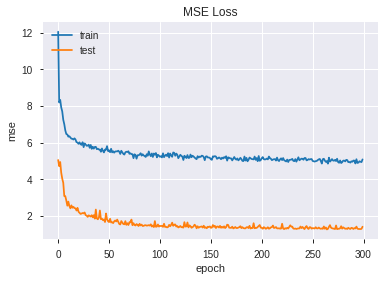

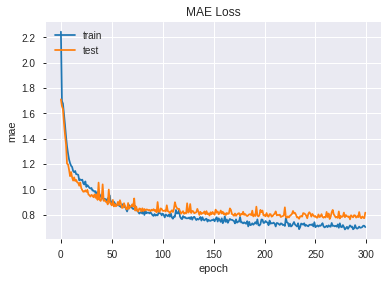

In [434]:
# list all data in history
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE Loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Compute Error Metrics

In [435]:
def error_metrics(y_test, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    n = len(y_test)

    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    print("The range for the output variable is: " + str(y_test.mean()))
    print("r2score : " + str(r2_Score))
    print("adjusted r2score : " + str(adjusted_r2))
    print("mae : " + str(mae_score))
    print("rmse : " + str(rmse_score))
    print("mse : " + str(mse_score))
    print("re : " + str(re))
    print("mape : " + str(mape_score))
    
nb_columns = len(list(df.columns.values)) - 1
error_metrics(Y_test, Y_predict)
print("------------------------------------------------")
print("Best Hyper Parameters:", grid_search[index])

The range for the output variable is: 3.153639850094837
r2score : 0.7910836296007412
adjusted r2score : 0.7590412415026954
mae : 0.6991356212476916
rmse : 1.0401563677487562
mse : 1.081925269368286
re : 38.56270586112432
mape : 316.6863689579017
------------------------------------------------
Best Hyper Parameters: {'HP_LEARNING_RATE': 0.01, 'HP_MOMENTUM': 0.5, 'HP_OPTIMIZER': 'adam', 'HP_NUM_UNITS2': '64', 'HP_NUM_UNITS1': '64', 'HP_L2': 0.001, 'HP_BATCH_SIZE': 64, 'HP_EPOCHS': 300, 'HP_LOSS': 'mean_squared_logarithmic_error', 'HP_INIT': 'uniform', 'HP_LAYER_SIZE': 1, 'HP_DROPOUT': 0.2, 'HP_ACTIVATION': 'relu'}


In [396]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

accuracy      loss       mae        mse  val_accuracy  val_loss  \
295  0.000000  0.854904  0.815272  49.798454           0.0  0.734705   
296  0.000000  0.852291  0.812566  49.695580           0.0  0.728842   
297  0.000000  0.858199  0.818423  49.746357           0.0  0.743753   
298  0.000000  0.854400  0.814583  49.782509           0.0  0.752024   
299  0.000052  0.853972  0.814313  49.691978           0.0  0.731459   

      val_mae   val_mse  epoch  
295  0.695193  2.234060    295  
296  0.689091  2.212506    296  
297  0.703934  2.259829    297  
298  0.712360  2.264410    298  
299  0.691890  2.212806    299

References: 
<br>
https://medium.com/ml-book/neural-networks-hyperparameter-tuning-in-tensorflow-2-0-a7b4e2b574a1  
https://github.com/senkmp/TensorFlow-2.0/blob/master/feature_columns.ipynb   

In [ ]:
# ########################################################################################################################
#                                             #Grid Search
# ########################################################################################################################

# #The best hyper-params in random search were the following:
# #{'n_trees': 150, 'max_depth': 7, 'learning_rate': 0.3, 'l2_regularization': 0.01, 'l1_regularization': 0.01}  is the best hyper-params

# #Thus, we shall do gridsearch around these hyper-params:

# #get grid of all hyper-parameters
# def get_param_grid(dicts):
#   return [dict(zip(dicts.keys(), p)) for p in it.product(*dicts.values())]

# def get_fold_indices(X,y,n_splits):
#   splitter = KFold(n_splits=n_splits, shuffle=True, random_state=123)
#   folds = list(splitter.split(X, y))
#   return folds
 
# #using CV
# def model_fit_predict_CV(X, y, split, params):

#     X_train, y_train = X.iloc[split[0],:], y[split[0]]
#     X_valid, y_valid   = X.iloc[split[1],:], y[split[1]]
    
#     reg = _doFitBoostedTreeRegressor(X_train, y_train, X_train.columns, params)
#     y_pred = _doPredictBoostedTreeRegressor(X_valid, reg)
    
#     df_test = X_valid

#     # combine y_test and y_pred in 1 dataset
#     df_test['LE_man_corr(mm)'] = y_valid
#     df_test['LE_man_corr(mm)_pred'] = y_pred
    
#     mape = evaluate(df_test, actual='LE_man_corr(mm)', predicted='LE_man_corr(mm)_pred',
#              thresh=0.8, rel_method='extremes', extr_type='high',
#              coef=1.5, relevance_pts=None)
             
#     return mape

# def _doFitBoostedTreeRegressor(X, Y, columns, params):
#     # Define our feature columns
#     fc = tf.feature_column
#     feature_columns = []
#     NUMERIC_COLUMNS = columns

#     for feature_name in NUMERIC_COLUMNS:
#         feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

#     # Creating the TF dataset
#     train_input_fn = make_input_fn(X, Y)
#     #print(train_input_fn, 'train input fn')

#     # Defining the estimator (BoostedTreeRegressor)
#     n_batches = 2
#     est = tf.estimator.BoostedTreesRegressor(feature_columns, n_batches_per_layer=n_batches, **params)
#     # Training the Model
#     est.train(train_input_fn, max_steps=100)
#     print("done training for hyperparameter set" + str(params))
#     return est



# params_grid = {
#   'n_trees': [150,155,160],
#   'max_depth': [6,7],
#   'learning_rate' :  [0.01, 0.012],
#   'l1_regularization': [0.01, 0.012],
#   'l2_regularization' : [0.01, 0.012]
# }

# grid = get_param_grid(params_grid)

# ########################################################################################################################
#                                             #Grid Search + CV
# ########################################################################################################################

# repetitions = 2
# folds = 10

# mape_all = []
# for param in grid:
#     mape_rep = []
#     for rep in range(repetitions):
#         fold_indx = get_fold_indices(X_train,y_train,folds)
#         mape_folds = []
#         for fold in range(folds):
#             mape = model_fit_predict_CV(X_train,y_train, fold_indx[fold], param)
#             mape_folds.append(mape)
#         avg = np.average(mape_folds)
#         print("the average mape across folds is " + str(avg))
#         mape_rep.append(avg)
#     avg_rep = np.average(mape_rep)
#     mape_all.append(avg_rep)

# print(min(mape_all) , " is the best mape")
# index = mape_all.index(min(mape_all))
# print(grid[index], " is the best hyper-params")